In [1]:
from data_pipeline import PipelineGenerator

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

%matplotlib inline

In [2]:
metadata_file = "../data/final_dataset_val.csv"
wellington_images_dir = "../../dataset/images/" # Ensure the slash at the end.

pieline_gen = PipelineGenerator(metadata_file, wellington_images_dir, mode="single-all")

In [3]:
dataset_batches = pieline_gen.get_pipeline()

TypeError: `map_func` must return a `Dataset` object. Got <class 'tuple'>

In [16]:
type(dataset_batches)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [5]:
c = 0
for batch in dataset_batches:
    c += 1
    if c > 500:
        break

print(c)

414


In [6]:
type(batch)

tuple

In [7]:
images, labels = batch

In [12]:
images.shape

TensorShape([2448, 3264, 3])

In [14]:
img, label = batch

In [16]:
int(label)

1

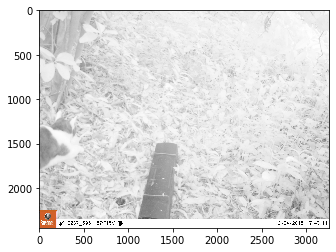

In [17]:
plt.imshow(img)

In [1]:
# Assuming we have dataset_batches working fine.

In [2]:
import tensorflow as tf

In [7]:
vgg16_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 873s 2us/step


In [8]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
vgg16_new_model = tf.keras.applications.VGG16(input_shape=(256, 256, 3), include_top=True, weights=None)

In [11]:
vgg16_new_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
# Custom build VGG16 model.
from tensorflow import keras
from tensorflow.keras import layers


def _add_conv_block(num_filters, inputs, is_training, name_prefix, kernel_regularizer=None):
    """Adds a Batchnorm enabled convolution block.
    """
    conv = layers.Conv2D(num_filters,
                         (3, 3),
                         activation=None,
                         padding="same",
                         kernel_regularizer=kernel_regularizer,
                         name="%s-Conv" % name_prefix)(inputs)
    batchnorm = layers.BatchNormalization(name="%s-BN" % name_prefix)(conv, training=is_training)
    relu = layers.ReLU(name="%s-Relu" % name_prefix)(batchnorm)
    return relu


def _add_dense_block(units, inputs, is_training, name_prefix, kernel_regularizer=None, dropout_rate=0.5):
    """Adds a Batchnorm and Dropout enabled dense block.
    """
    dense = layers.Dense(units, activation=None, name="%s-Dense" % name_prefix)(inputs)
    batchnorm = layers.BatchNormalization(name="%s-BN" % name_prefix)(dense, training=is_training)
    relu = layers.ReLU(name="%s-Relu" % name_prefix)(batchnorm)
    dropout = layers.Dropout(dropout_rate, name="%s-Dropout_%s" % (name_prefix, dropout_rate))(relu, training=is_training)
    return dropout


def vgg16(input_shape, is_training, num_classes=1):
    """
    Builds a vgg16 model with Batchnorm and Dropout layers.

    :param input_shape: THe shape of the input images (do not consider the batch-dimension).
    :param is_training: Flag to denote if the model would be used in training mode or not.
    :param num_classes: The number of classes. If it is binary classification, use num_classes=1.
    :return: The constructed tf.Keras model (Functional).

    """
    inputs = keras.Input(shape=input_shape, name='input')

    block1_conv1 = _add_conv_block(64, inputs, is_training, "block1_conv1")
    block1_conv2 = _add_conv_block(64, block1_conv1, is_training, "block1_conv2")
    block1_pool = layers.MaxPooling2D(name="block1_pool")(block1_conv2)

    block2_conv1 = _add_conv_block(128, block1_pool, is_training, "block2_conv1")
    block2_conv2 = _add_conv_block(128, block2_conv1, is_training, "block2_conv2")
    block2_pool = layers.MaxPooling2D(name="block2_pool")(block2_conv2)

    block3_conv1 = _add_conv_block(256, block2_pool, is_training, "block3_conv1")
    block3_conv2 = _add_conv_block(256, block3_conv1, is_training, "block3_conv2")
    block3_conv3 = _add_conv_block(256, block3_conv2, is_training, "block3_conv3")
    block3_pool = layers.MaxPooling2D(name="block3_pool")(block3_conv3)

    block4_conv1 = _add_conv_block(512, block3_pool, is_training, "block4_conv1")
    block4_conv2 = _add_conv_block(512, block4_conv1, is_training, "block4_conv2")
    block4_conv3 = _add_conv_block(512, block4_conv2, is_training, "block4_conv3")
    block4_pool = layers.MaxPooling2D(name="block4_pool")(block4_conv3)

    block5_conv1 = _add_conv_block(512, block4_pool, is_training, "block5_conv1")
    block5_conv2 = _add_conv_block(512, block5_conv1, is_training, "block5_conv2")
    block5_conv3 = _add_conv_block(512, block5_conv2, is_training, "block5_conv3")
    block5_pool = layers.MaxPooling2D(name="block5_pool")(block5_conv3)

    flatten = layers.Flatten(name="flatten")(block5_pool)
    fc1 = _add_dense_block(4096, flatten, is_training, "fc1")
    fc2 = _add_dense_block(4096, fc1, is_training, "fc2")

    if num_classes <= 2:
        predictions = layers.Dense(1, activation="sigmoid", name="prediction")(fc2)
    else:
        predictions = layers.Dense(num_classes, activation="softmax", name="prediction")(fc2)

    model = keras.Model(inputs=inputs, outputs=predictions, name="vgg16_model")
    return model


In [14]:
vgg16_custom_model = vgg16((256, 256, 3), True, num_classes=1)

In [15]:
vgg16_custom_model.summary()

Model: "vgg16_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1-Conv (Conv2D)   (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv1-BN (BatchNormal (None, 256, 256, 64)      256       
_________________________________________________________________
block1_conv1-Relu (ReLU)     (None, 256, 256, 64)      0         
_________________________________________________________________
block1_conv2-Conv (Conv2D)   (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_conv2-BN (BatchNormal (None, 256, 256, 64)      256       
_________________________________________________________________
block1_conv2-Relu (ReLU)     (None, 256, 256, 64)      

In [16]:
vgg16_custom_model.fit?